In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns


import statsplot as stp

from statsplot import MetaTable

# Simple example

We create first some dummy data for weights for three treatments


In [ ]:
np.random.seed(0)


N = 8
group_names = ["Control", "Treatment 1", "Treatment 2"]

groups = pd.Series(
    np.repeat(group_names, N),
    index=[f"Participant_{i+1}" for i in range(N * len(group_names))],
    name="Group",
)
weights = pd.Series(
    data=np.random.randn(groups.shape[0], 1)[:, 0] * 5 + 15,
    index=groups.index,
    name="Weight",
)
# add difference between groups
weights += groups.map(dict(zip(group_names, [0, 0.1, 10]))).values

We can plot this data elegantly with seaborn

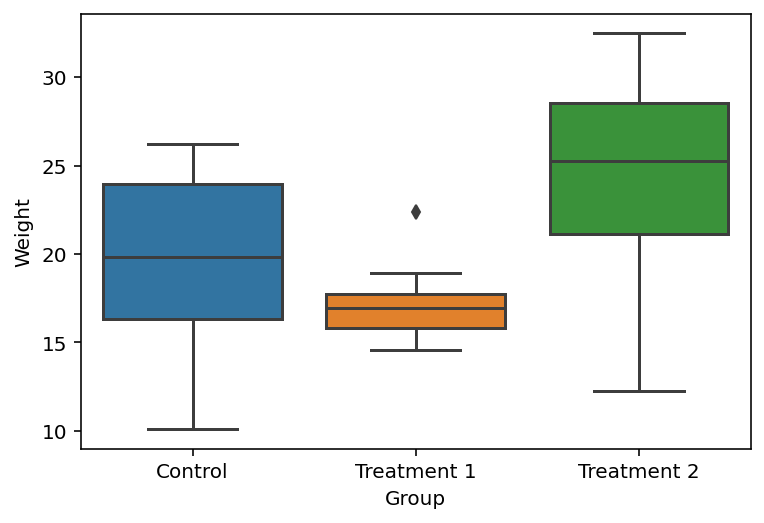

In [ ]:
ax = sns.boxplot(y=weights, x=groups)

If you want to know and plot significance on the plot we can simply use satatsplot with almost the same API

Treatment 1_vs_Control        0.338836
Treatment 2_vs_Control        0.117191
Treatment 2_vs_Treatment 1    0.010854
Name: Weight, dtype: float64

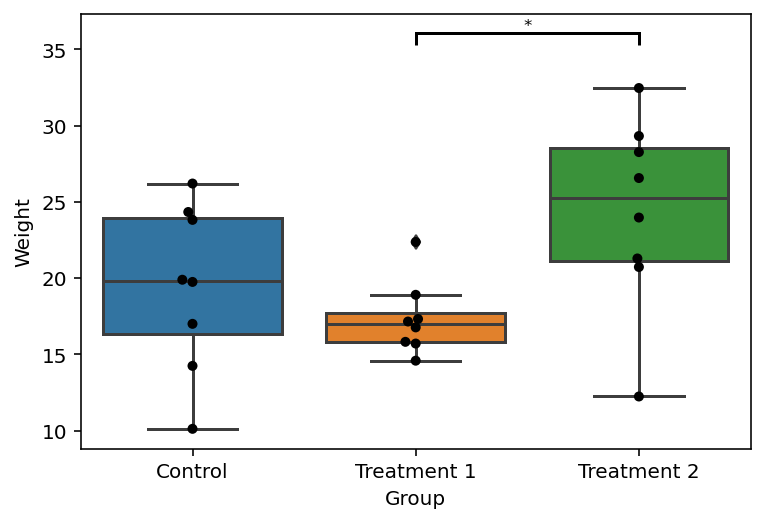

In [ ]:
ax, stats = stp.statsplot(variable=weights, test_variable=groups)

stats

If you want to show the value instead of the start you can modify the sig labels.

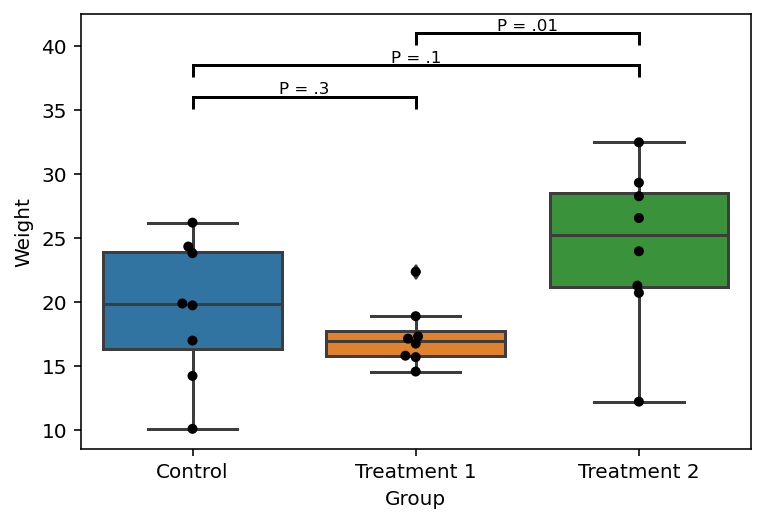

In [ ]:
ax, stats = stp.statsplot(
    variable=weights,
    test_variable=groups,
    labelkws={"show_ns": True, "use_stars": False},
)

# Example with nested groups

In [ ]:
# create data from above groups with before treatment and after treatment time point

df = pd.DataFrame(groups).reset_index().rename(columns={"index": "Participant"})

df_before = df.copy()
df_before["Timepoint"] = "before"
df_before["Measurement"] = np.random.randn(df.shape[0], 1)[:, 0] * 5 + 12

df_after = df.copy()
df_after["Timepoint"] = "after"
df_after["Measurement"] = weights.values

df = pd.concat([df_before, df_after], ignore_index=True)
del df_before, df_after

df.index = "Sample_" + df.index.astype(str)

df.head()

,Participant,Group,Timepoint,Measurement
Sample_0,Participant_1,Control,before,23.348773
Sample_1,Participant_2,Control,before,4.728172
Sample_2,Participant_3,Control,before,12.228793
Sample_3,Participant_4,Control,before,11.064081
Sample_4,Participant_5,Control,before,19.663896


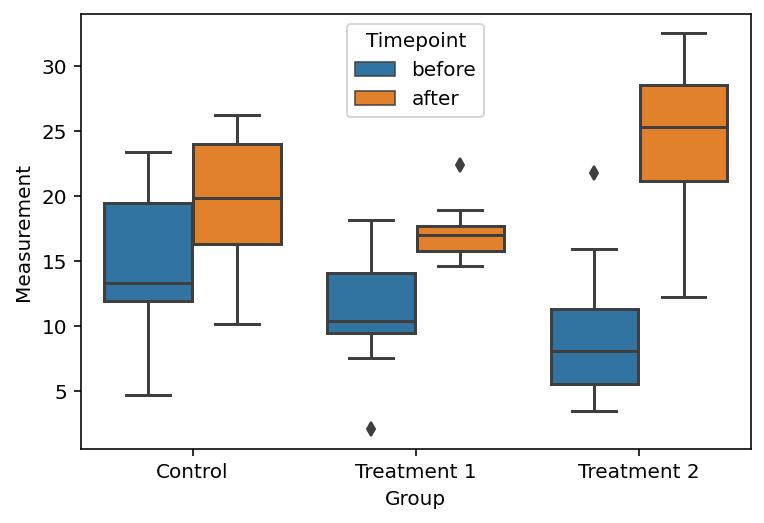

In [ ]:
ax = sns.boxplot(
    data=df, y="Measurement", hue="Timepoint", x="Group", hue_order=["before", "after"]
)

Control      before_vs_after    0.120447
Treatment 1  before_vs_after    0.013041
Treatment 2  before_vs_after    0.005731
Name: Measurement, dtype: object

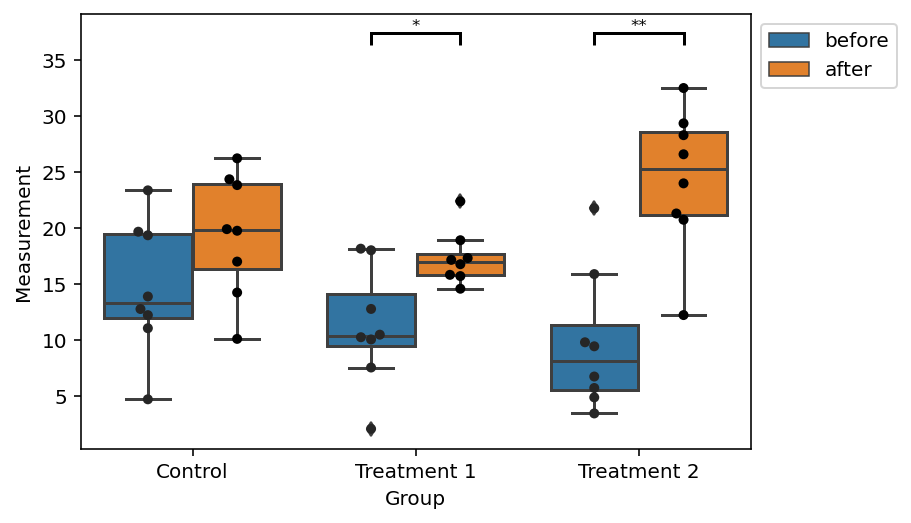

In [ ]:
# and here the statsplot version of it.
# see we use paired ttest as we compate the same patients before and after treatment

ax, stats = stp.statsplot(
    variable=df.Measurement,
    test_variable=df.Timepoint,
    grouping_variable=df.Group,
    test="ttest_rel",
    order_test=["before", "after"],
)
stats

# Example with many variables

If you have many similar values you can put them in a `StatsTable` and then apply statistics once.
This example is based on on microbiome profiling

In [ ]:
# Functions to parse taxonomy
import pandas as pd
import numpy as np
import warnings

TAXONMIC_LEVELS = ["Domain", "phylum", "class", "order", "family", "genus", "species"]


def tax2table(Taxonomy_Series, split_character=";", remove_prefix=False):
    """
    Transforms (green_genes) taxonomy to a table
    Expect the following input format:
    d__Bacteria;p__Bacteroidota;c__Bacteroidia;f__
    Replaces empty values and can remove prefix 'c__'
    """

    # drop missing values
    if Taxonomy_Series.isnull().any():
        warnings.warn(
            "Some samples have no taxonomy asigned. Samples:\n"
            + ", ".join(Taxonomy_Series.index[Taxonomy_Series.isnull()].astype(str))
        )

    Tax = Taxonomy_Series.dropna().astype(str).str.split(split_character, expand=True)
    # Add headers as long as we have columns
    Tax.columns = TAXONMIC_LEVELS[: len(Tax.columns)]

    if remove_prefix:
        Tax = Tax.applymap(lambda s: s[3:], na_action="ignore").replace("", np.nan)
    else:
        Tax[Tax.applymap(len, na_action="ignore") == 3] = np.nan

    # add missing values again

    Tax = Tax.reindex(Taxonomy_Series.index)

    return Tax


def load_gtdb_tax(taxonomy_file, remove_prefix=False):

    D = pd.read_table(taxonomy_file, index_col=0)

    Tax = tax2table(D["classification"], remove_prefix=remove_prefix)

    return Tax

In [ ]:
# load microbiome data
# The paths here are existing only on my computer

# 1. counts/ relab
# 2. taxonomy
# 3. metadata

Tax = load_gtdb_tax(
    "../WarmMicrobiota/Metagenome/WD/genomes/taxonomy/gtdbtk.bac120.summary.tsv",
    remove_prefix=True,
).sort_index()

# create a label for each genome even if species is not defined

Tax["Label"] = Tax.ffill(axis=1)["species"]
Tax.loc[Tax.species.isnull(), "Label"] += " " + Tax.index[Tax.species.isnull()]


metadata = pd.read_table("../WarmMicrobiota/Metagenome/metadata.tsv", index_col=0)
D = pd.read_table(
    "../WarmMicrobiota/Metagenome/WD/genomes/counts/median_coverage_genomes.tsv",
    index_col=0,
)
# relative abundance
relab = (D.T / D.sum(1)).T * 100

In [ ]:
# transform data with centered log transform

from statsplot import transformations

clr_data = transformations.clr(relab, log=np.log2)

# put everithing together in a MetaTable

D = MetaTable(clr_data, obs=metadata, var=Tax)
D

MetaTable with 32 samples x 147 features

In [ ]:
# create stats table

ST = stp.StatsTable(
    D,
    test_variable="Group",
    grouping_variable="Source",
    label_variable="Label",
    data_unit="centered log$_2$ ratio",
    test="welch",
    ref_group="RT",
)

Your labels are not unique. but I should be able to handle this.


In [ ]:
ST.stats

Pvalue               Statistic            median_diff            \
           Cecum         Feces     Cecum      Feces       Cecum     Feces   
       Hot_vs_RT     Hot_vs_RT Hot_vs_RT  Hot_vs_RT   Hot_vs_RT Hot_vs_RT   
MAG001  0.000086  9.776735e-08 -7.182472 -10.031165    3.871136  4.234078   
MAG002  0.836514  5.090102e-01 -0.210302  -0.680390   -0.065014 -0.113144   
MAG003  0.582932  7.263050e-01 -0.563255  -0.358060    0.018494  0.192080   
MAG004  0.026453  4.278596e-02  2.575495   2.252542   -1.051217 -1.638859   
MAG005  0.006127  5.384854e-02  3.267759   2.104872   -1.349585 -0.650092   
...          ...           ...       ...        ...         ...       ...   
MAG143  0.011926  1.485766e-02  2.972029   2.840871   -2.133191 -2.072522   
MAG144  0.154094  1.801576e-01  1.595590   1.483567   -0.274400 -0.178421   
MAG145  0.114007  5.550921e-02 -1.685909  -2.101932    0.352819  1.037689   
MAG146  0.121707  8.657415e-02  1.671672   1.863180   -2.149775 -2.022352   
MAG147  0.684818  3.889712e-01  0.414712   0.898177   -0.281860 -0.238357   

             pBH            
           Cecum     Feces  
       Hot_vs_RT Hot_vs_RT  
MAG001  0.001576  0.000014  
MAG002  0.924569  0.699294  
MAG003  0.745140  0.847356  
MAG004  0.092516  0.131032  
MAG005  0.032168  0.153960  
...          ...       ...  
MAG143  0.053698  0.065756  
MAG144  0.300687  0.343093  
MAG145  0.246456  0.153960  
MAG146  0.259169  0.215702  
MAG147  0.829402  0.589886  

[147 rows x 8 columns]

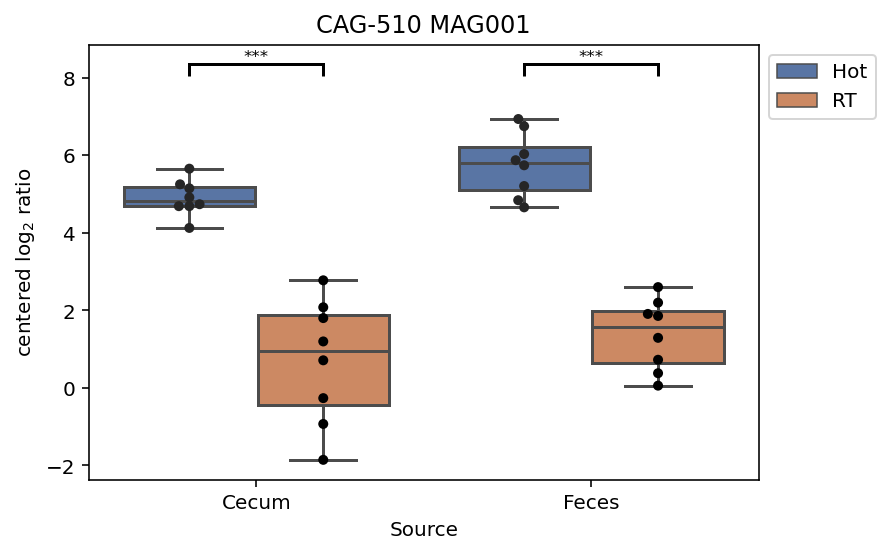

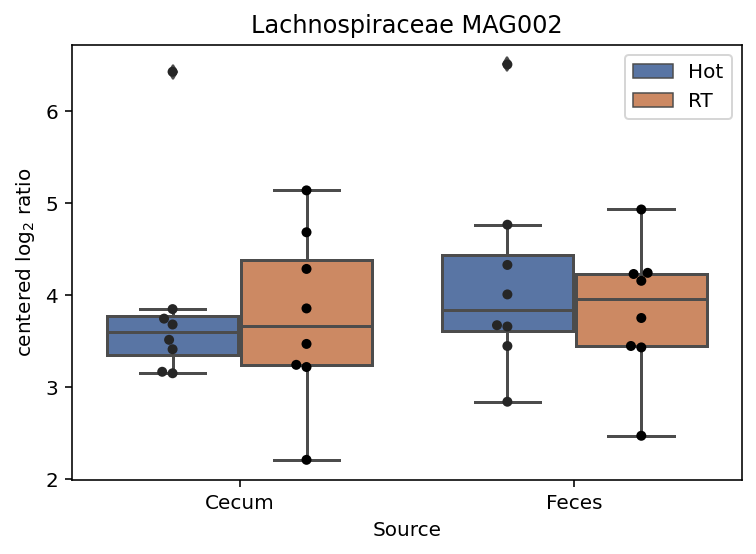

In [ ]:
ST.plot("MAG001")
plt.show()
ST.plot("MAG002")

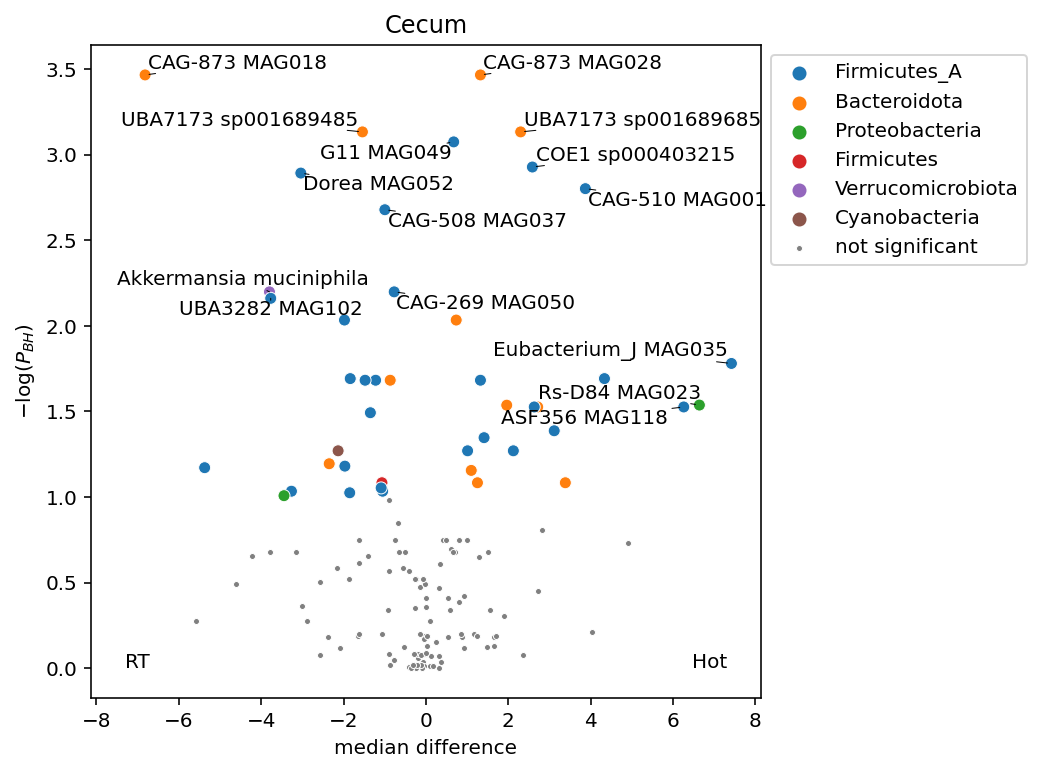

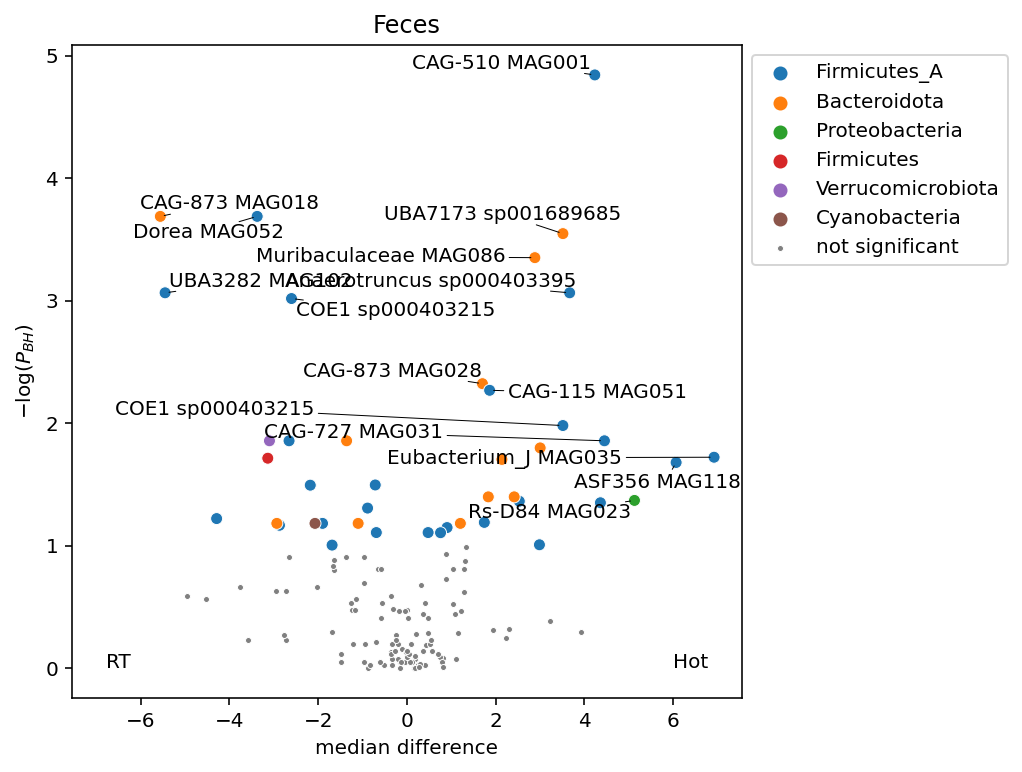

In [ ]:
# make a vulcanot

axes = ST.vulcanoplot(hue="phylum")

# PCA

The following functions represent commonly used plots for dimensional reduction


In [ ]:
from statsplot import DimRed

pca = DimRed(clr_data)

<AxesSubplot:xlabel='Principal Component', ylabel='Explained Variance Ratio'>

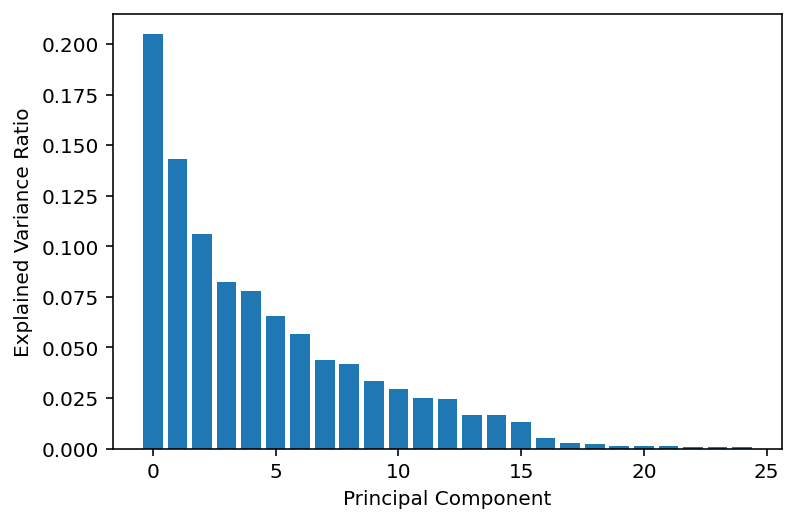

In [ ]:
pca.plot_explained_variance_ratio()

<AxesSubplot:xlabel='PC 1 [20.5 %]', ylabel='PC 2 [14.3 %]'>

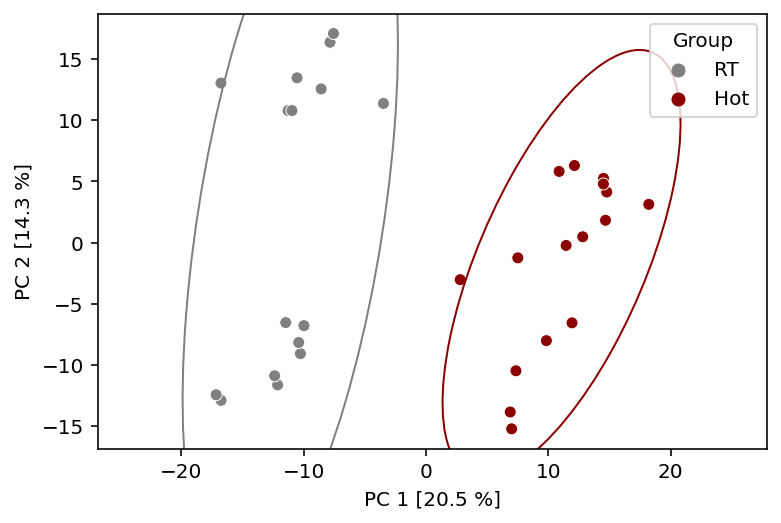

In [ ]:
pca.plot_components(
    plot_ellipse=True,
    groups=metadata.Group,
    order_groups=["RT", "Hot"],
    colors=["grey", "darkred"],
)

<AxesSubplot:xlabel='PC 1 [20.5 %]', ylabel='PC 2 [14.3 %]'>

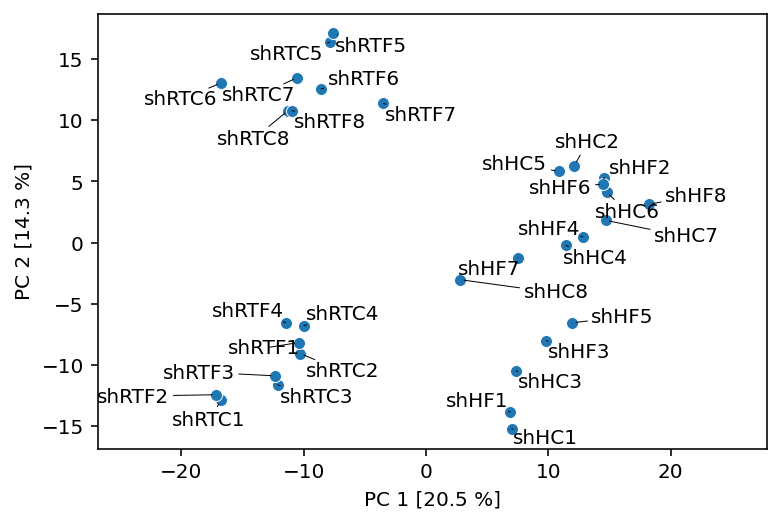

In [ ]:
pca.plot_components(label_points=True)

automatic selection selected 10 to visualize, which is probably to much. I select only 8


<AxesSubplot:xlabel='PC 1 [20.5 %]', ylabel='PC 2 [14.3 %]'>

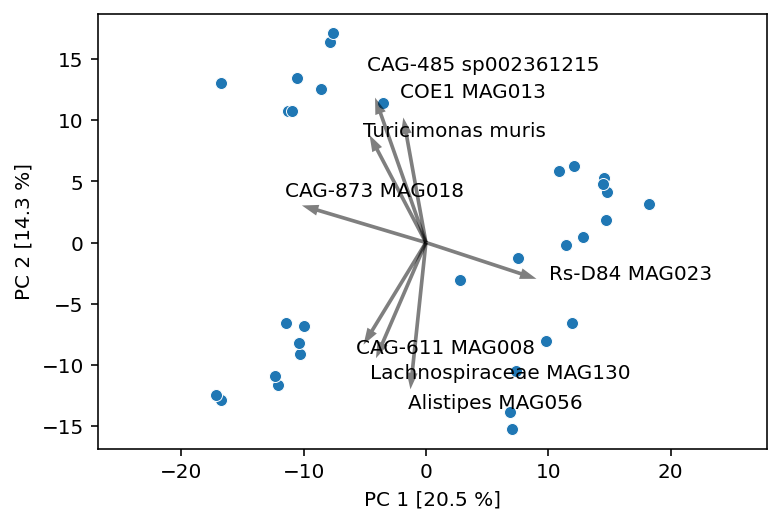

In [ ]:
pca.plot_biplot(labels=Tax.Label)

# Stats table with one grouping variable 

This is to show how to construct a statstable without the MetaTable and for testing

In [ ]:
# create stats table

ST = stp.StatsTable(
    relab,
    test_variable=metadata.Group,
    label_variable=Tax.Label,
    data_unit="Relative abundance",
    test="mannwhitneyu",
    ref_group="RT",
)

Your labels are not unique. but I should be able to handle this.


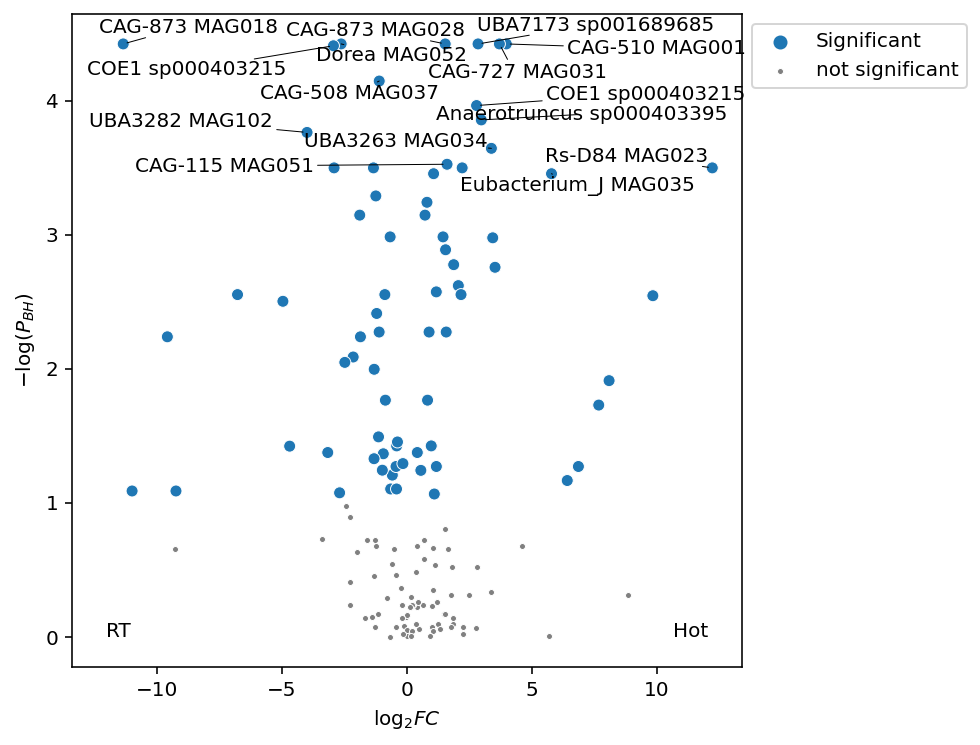

In [ ]:
ST.vulcanoplot()

In [ ]:
ST.stats
# keep in mind that the stats table here has one header row less than if used with a grouping variable

,Pvalue,Statistic,log2FC,median_diff,pBH
,Hot_vs_RT,Hot_vs_RT,Hot_vs_RT,Hot_vs_RT,Hot_vs_RT
MAG001,0.000002,0.0,3.979037,4.355420,0.000038
MAG002,0.462380,108.0,0.413565,0.155043,0.596227
MAG003,0.338839,106.0,1.745871,0.000000,0.488326
MAG004,0.010959,196.0,-1.138110,-0.081953,0.032220
MAG005,0.000975,216.0,-1.211975,-0.668275,0.003872
...,...,...,...,...,...
MAG143,0.003091,207.0,-1.311170,-0.851287,0.010096
MAG144,0.038849,160.0,-9.247887,0.000000,0.081583
MAG145,0.005603,54.0,0.824869,0.233811,0.017160


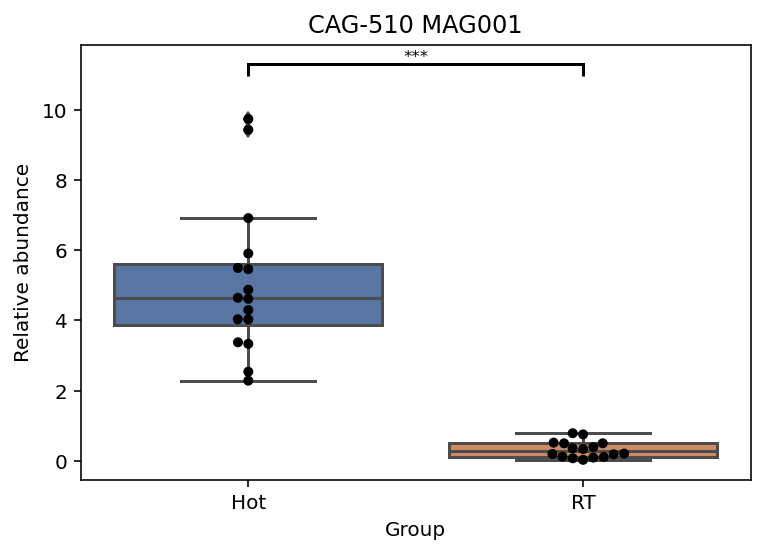

In [ ]:
ST.plot("MAG001")